Data Preprocessing

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

c:\Users\zoech\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
#load data
file_path = 'train_sortiert_new_format.csv'
df = pd.read_csv(file_path)
df.head()

,video_id,label_id,label,F1_L0_X,F1_L0_Y,F1_L0_Z,F1_L1_X,F1_L1_Y,F1_L1_Z,F1_L2_X,...,F37_L17_Z,F37_L18_X,F37_L18_Y,F37_L18_Z,F37_L19_X,F37_L19_Y,F37_L19_Z,F37_L20_X,F37_L20_Y,F37_L20_Z
0,1000,11,Sliding Two Fingers Left,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,20,Thumb Up,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,11,Sliding Two Fingers Left,0.269611,0.937481,4.710461e-07,0.302779,0.850025,-0.027882,0.300107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100031,12,Sliding Two Fingers Right,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,19,Thumb Down,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#split into target and data
target = df['label_id']
data = df.iloc[:,3:]
print("data: ",data.shape)
print("label:", target.shape)

data:  (16318, 2331)
label: (16318,)


In [5]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(data,target,random_state=1,test_size=0.2,shuffle=True)

In [6]:
#print shape
print('X_train : ') 
print(X_train.shape) 
print('') 
print('X_test : ') 
print(X_test.shape) 
print('') 
print('y_train : ') 
print(y_train.shape) 
print('') 
print('y_test : ') 
print(y_test.shape)

X_train : 
(13054, 2331)

X_test : 
(3264, 2331)

y_train : 
(13054,)

y_test : 
(3264,)


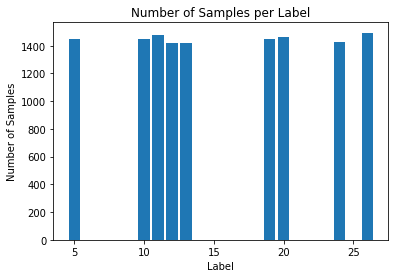

Label '5': 1449 samples
Label '10': 1452 samples
Label '11': 1475 samples
Label '12': 1419 samples
Label '13': 1418 samples
Label '19': 1452 samples
Label '20': 1465 samples
Label '24': 1430 samples
Label '26': 1494 samples


In [7]:
#distribution of training data

# Get unique labels and their counts
unique_labels, counts = np.unique(y_train, return_counts=True)

# Plotting
plt.bar(unique_labels, counts)
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Label')
plt.show()

# Print unique labels and their counts
for label, count in zip(unique_labels, counts):
    print(f"Label '{label}': {count} samples")

Model Training

In [8]:
#import training libraries
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [9]:
#Logistic Regression
clr = LogisticRegression(max_iter=2000, random_state=1)
clr.fit(X_train, y_train)

#predict training and new data
y_train_pred = clr.predict(X_train) 
y_test_pred = clr.predict(X_test)

#evaluation of the prediction
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Training Set Accuracy:", train_accuracy)
print("Test Set Accuracy:", test_accuracy)

Training Set Accuracy: 0.7953117818293244
Test Set Accuracy: 0.7653186274509803


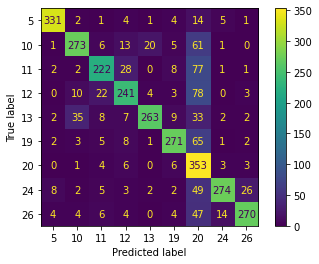

In [10]:
#Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=clr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clr.classes_)
disp.plot()

First impression:
There seems to be an issue with label 20 "Thumb Up". Although the true label 20 is often correctly predicted as 20, many other classes are also predicted as label 20, although they belong to another label. Idea: leave out gesture 20, since it's not that relevant for our project.
Additionally, also out training accuracy is too low. We should try to improve it. 

In [11]:
#filter dataframe
filtered_df = df[df['label_id'] != 20]

#split into target and data
target = filtered_df['label_id']
data = filtered_df.iloc[:,3:]

#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(data,target,random_state=1,test_size=0.2,shuffle=True)



In [14]:
#Create Model
clr_filtered = LogisticRegression(max_iter=2000, random_state=1)
clr_filtered.fit(X_train, y_train)

#predict training and new data
y_train_pred = clr_filtered.predict(X_train) 
y_test_pred = clr_filtered.predict(X_test)

#evaluation of the prediction
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Training Set Accuracy:", train_accuracy)
print("Test Set Accuracy:", test_accuracy)

Training Set Accuracy: 0.8085657542526552
Test Set Accuracy: 0.774171270718232


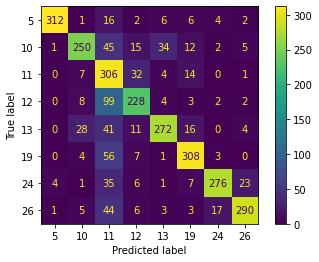

In [15]:
#Plot the Confusion Matrix
cm_filtered = confusion_matrix(y_test, y_test_pred, labels=clr_filtered.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_filtered,display_labels=clr_filtered.classes_)
disp.plot()

Result: The filtered version didn't increase the training accuracy, but improved the test accuracy. I think it's worth to continue with the filtered version. 

Continue with an Neural Network (MLPClassifier)

In [16]:
#standardize data
scaler = StandardScaler()
# Fit only on the training data
scaler.fit(X_train)
# Apply the transformations to the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Create an MLPClassifier

hidden_layer_sizes = (100, 50) #change sizes if necessary
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

#evaluation of the prediction
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)

Test Set Accuracy: 0.7458563535911602


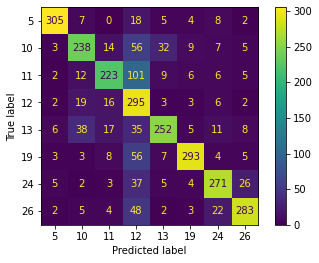

In [18]:
#Plot the Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,display_labels=mlp.classes_)
disp.plot()

try to improve with hyperparameter tuning

In [19]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Create an MLPClassifier
mlp2 = MLPClassifier(max_iter=1000, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the results for each parameter setting
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Print the best parameters found by GridSearchCV
print("\nBest parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_mlp = grid_search.best_estimator_
y_test_pred = best_mlp.predict(X_test)

#Evaluation of the prediction
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Set Accuracy:", test_accuracy)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
                                               params  mean_test_score  \
0   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...         0.728521   
1   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...         0.728521   
2   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...         0.735084   
3   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...         0.735084   
4   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...         0.713153   
5   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...         0.713153   
6   {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.733357   
7   {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.733357   
8   {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.729990   
9   {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.729990   
10  {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.717125   
11  {'activation': 'tanh', 'alpha': 0.01, 'hidden_.

MLP Classifier doesn't seem to work very well, or the parameters are still not right adjusted. So let's try another Classifier.

Use XGBoost Classifier

In [20]:
#encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# Create an XGBoost classifier
cl_xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=8, random_state=42, use_label_encoder=False)

# Train the model
cl_xgb.fit(X_train, y_train_encoded)

#predict training and new data
y_train_pred = cl_xgb.predict(X_train) 
y_test_pred = cl_xgb.predict(X_test)

#evaluation of the prediction
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print("Training Set Accuracy:", train_accuracy)
print("Test Set Accuracy:", test_accuracy)


[11:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Set Accuracy: 0.8991451515413177
Test Set Accuracy: 0.7793508287292817


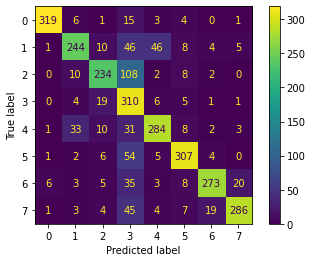

In [21]:
#Plot the Confusion Matrix
cm_xgb = confusion_matrix(y_test_encoded, y_test_pred, labels=cl_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,display_labels=cl_xgb.classes_)
disp.plot()

Accuracy seems to increase. These are the best accuracy values so far. We should continue with techniques to reduce the dimensionality, since we have a lot of columns. Since validation dataset is smaller, one solution is to run this code on the test dataset, which has more rows.

In [22]:
#feature selection technique one

from sklearn.feature_selection import SelectKBest, f_classif

#Select top k features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=1000)  # Adjust k as needed

# Fit selector on training data and transform it
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)  # Transform test data using the same selector

#test with xgboost
cl_xgb2 = xgb.XGBClassifier(objective='multi:softmax', num_class=8, random_state=42, use_label_encoder=False)

# Train the model
cl_xgb2.fit(X_train_selected, y_train_encoded)

#predict training and new data
y_train_pred = cl_xgb2.predict(X_train_selected) 
y_test_pred = cl_xgb2.predict(X_test_selected)

#evaluation of the prediction
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print("Training Set Accuracy:", train_accuracy)
print("Test Set Accuracy:", test_accuracy)

[11:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Set Accuracy: 0.8920645885502115
Test Set Accuracy: 0.7551795580110497


This method decreases accuracy, so we should proceed with another technique. 

Try to improve LogisticRegression again:

In [12]:
clf_log = LogisticRegression(solver='saga', max_iter=2000, random_state=1)

# Set up the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2']  # SAGA supports both L1 and L2 regularization
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=clf_log, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the model using the best hyperparameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
y_pred_train = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {accuracy_train}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy}")

#best: C:1 , penalty: l2, Accuracy: 0.774

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'C': 1, 'penalty': 'l2'}
Training Accuracy: 0.807702270961057
Test Set Accuracy: 0.7745165745856354
